# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

In [2]:
def fes_1d(data,sim_parameters,params="^cv"):
    #-- estimation of Free Energy Surface --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig, ax = plt.subplots(figsize=(6,6))
    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            temp=sim_parameters["temp"],
                                            kbt=sim_parameters["kbt"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
    ax.grid()
    plt.tight_layout()
    ax.set_xlabel(r"$(cv1,cv2)$")
    ax.set_ylabel("FES [Kj/mol]")

    plt.show()

def fes_2d(data,sim_parameters,params="^cv"):
    #-- 2D plot --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig,ax_scatter = plt.subplots(1,1,figsize=(10,8))
    
    fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                        #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
    bounds = np.arange(0, 60, 5.)
    cmap = plt.cm.get_cmap('fessa',len(bounds))
    colors = list(cmap(np.arange(len(bounds))))
    cmap = mpl.colors.ListedColormap(colors[:-1], "")
    # set over-color to last color of list 
    cmap.set_over("white")
    c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]"
    )
    c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    ax_scatter.legend(["FES [Kj/mol]"])
    c.clabel()
    ax_scatter.grid()
    ax_scatter.set_xlabel(r"$CV1$")
    ax_scatter.set_ylabel(r"$CV2$")

# Simulation parameters 

In [3]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
folder = "unbias_A/"
# simulated data from unbias simulation
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
# benchmark data for comparison
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

# Different lags $\Delta \lambda$

In [14]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',#'tanh',
              'lag_time':5,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':5e-5,#1e-3, con questo lrate è molto oscillate la loss function
              'l2_reg':0.,
              'num_epochs':2000,
              'earlystop':True,
              'es_patience':300,
              'es_consecutive':True,#False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": False,
              "path_cpp": None
              }
#--------------------------------------#

In [35]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,18,25]
time = []
seeds = [21,151]#,500,1203,4045]
for seed in seeds:
    timescale = np.empty(len(lags))
    for i,lag in enumerate(lags):
        train_parameters["lag_time"] = lag
        #print("lag time ", lag)
        torch.manual_seed(seed)
        model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

        #-- move the model back to cpu for convenience --# 
        model.to('cpu')

        #-- print some useful results --#
        #print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
        #print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
        #print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])
        timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
    time.append(timescale)

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -1.214      -1.208      0.676  0.539  
1000  -1.264      -1.264      0.689  0.575  
1500  -1.282      -1.285      0.695  0.587  
2000  -1.299      -1.302      0.700  0.599  
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -0.924      -0.907      0.611  0.313  
1000  -1.043      -1.028      0.616  0.427  
1500  -1.065      -1.048      0.630  0.435  
2000  -1.106      -1.087      0.668  0.438  
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -0.735      -0.726      0.544  0.191  
1000  -0.883      -0.869      0.548  0.336  
1500  -0.904      -0.892      0.559  0.345  
2000  -0.931      -0.919      0.581  0.350  
Epoch Train Loss  Valid Loss  Eigenvalues             
500   -0.610      -0.607      0.486  0.124  
1000  -0.696      -0.693      0.491  0.205  
1500  -0.728      -0.723      0.506  0.222  
2000  -0.755      -0.745      0.529  0.226  
Epoch Train Loss  Valid Loss  Eigenvalues             
500  

[0.10134745 0.22954279 0.23112786 0.30315238 0.31633589 0.24723753
 0.1332117  0.16483013 0.24585178 0.24890536 0.16980591 0.15430982
 0.18087786 0.09238655 0.10557079]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


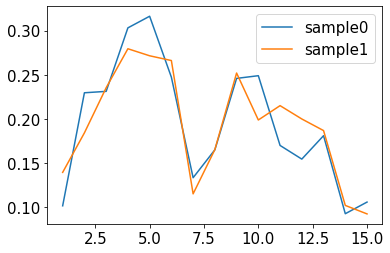

In [36]:
for j,el in enumerate(time):
    plt.plot(lags,el,label="sample"+str(j))
plt.legend()
print(time[0])
print(lags)

# Seed = 4045

## DeepTICA Analysis and Export
Select lag time

In [37]:
train_parameters["lag_time"] = 9 #9,10 è quello usato nella simulazione

In [38]:
# append models for comparison
models = []
torch.manual_seed(4045)
train_parameters["num_epochs"]=3000
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -0.323      -0.317      0.294  0.029  
1000  -0.342      -0.332      0.301  0.041  
1500  -0.377      -0.339      0.316  0.060  
2000  -0.410      -0.349      0.324  0.086  
2500  -0.427      -0.351      0.328  0.099  
INFO: Early stopping
2971  -0.436      -0.352      0.330  0.106  
timescales:  [8.12009  4.010791]
eigenvalues:  [0.33009917 0.10603918]
gap:  0.22405998


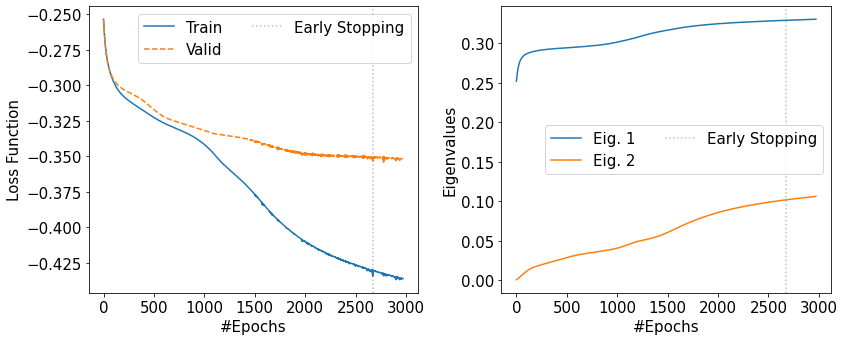

In [39]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [40]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

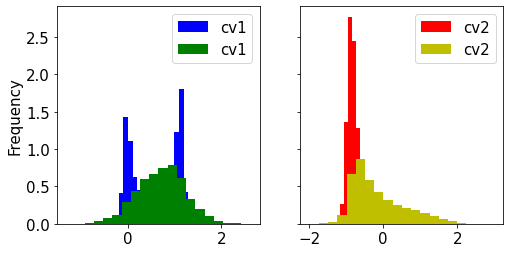

In [41]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

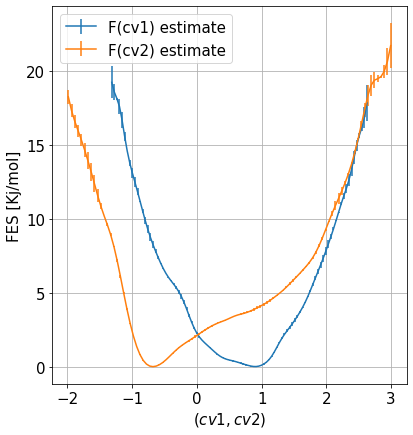

In [42]:
fes_1d(data_complete,sim_parameters)

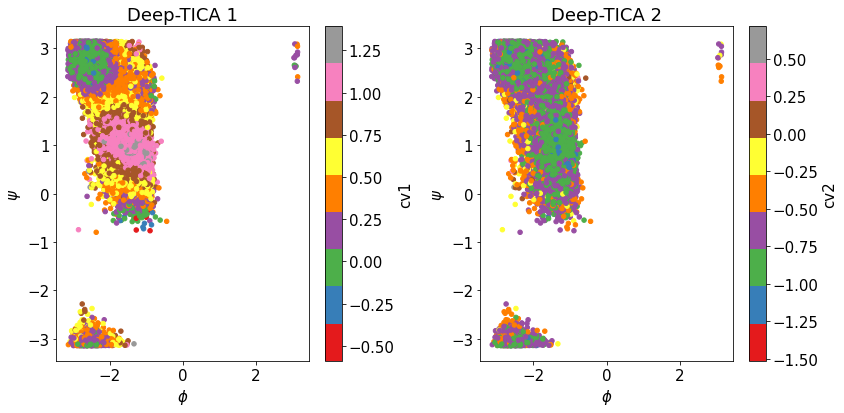

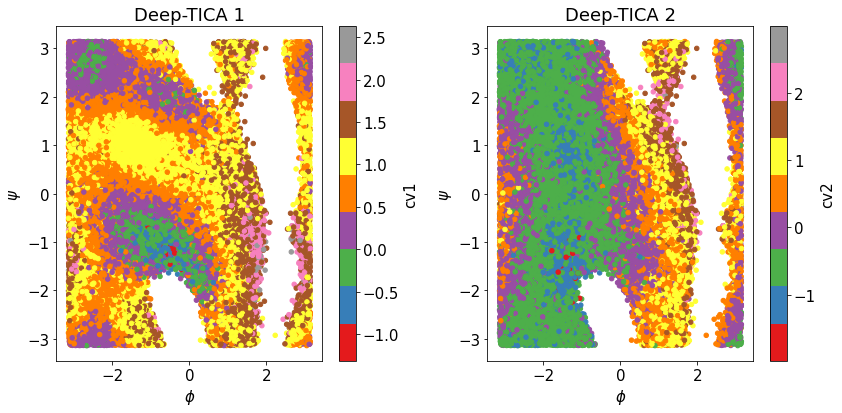

In [43]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [44]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.48739814549471977

# Seed = 35

## DeepTICA Analysis and Export

In [45]:
torch.manual_seed(35)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -0.324      -0.317      0.293  0.031  
1000  -0.333      -0.325      0.295  0.038  
1500  -0.345      -0.337      0.300  0.045  
2000  -0.374      -0.346      0.314  0.059  
INFO: Early stopping
2217  -0.388      -0.338      0.318  0.070  
timescales:  [7.8534136 3.379235 ]
eigenvalues:  [0.31790635 0.06971604]
gap:  0.24819031


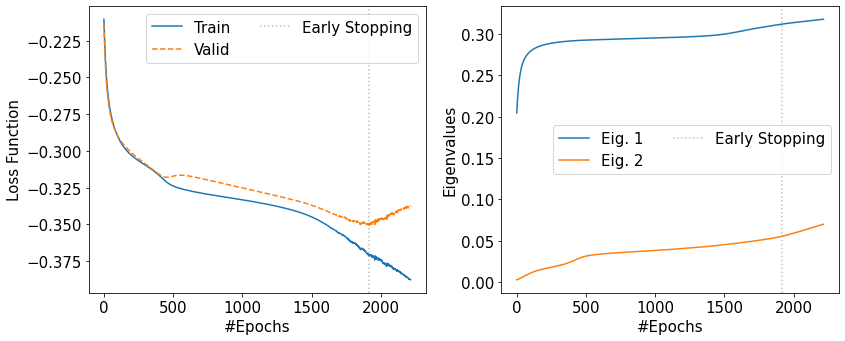

In [46]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [47]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

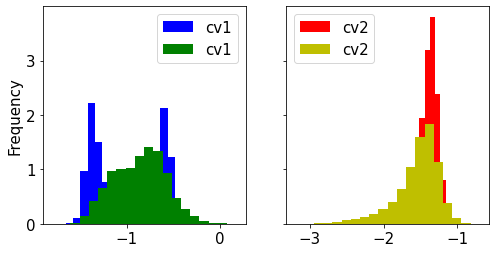

In [48]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

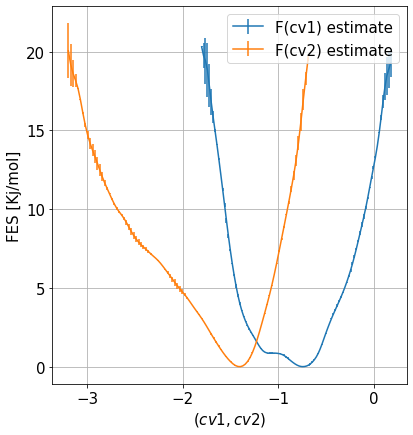

In [49]:
fes_1d(data_complete,sim_parameters)

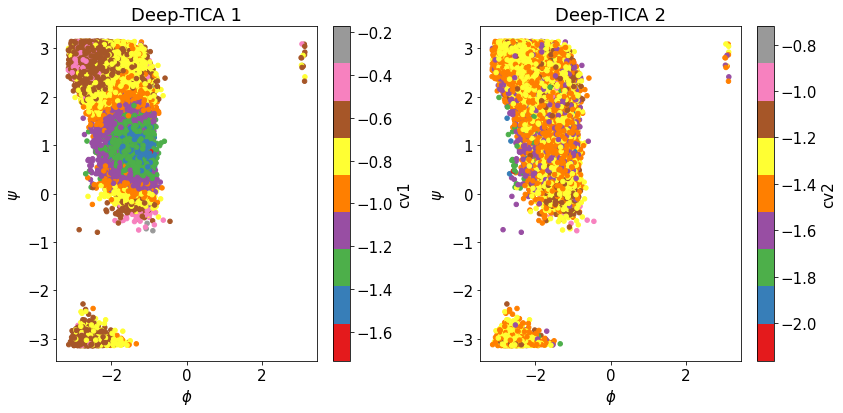

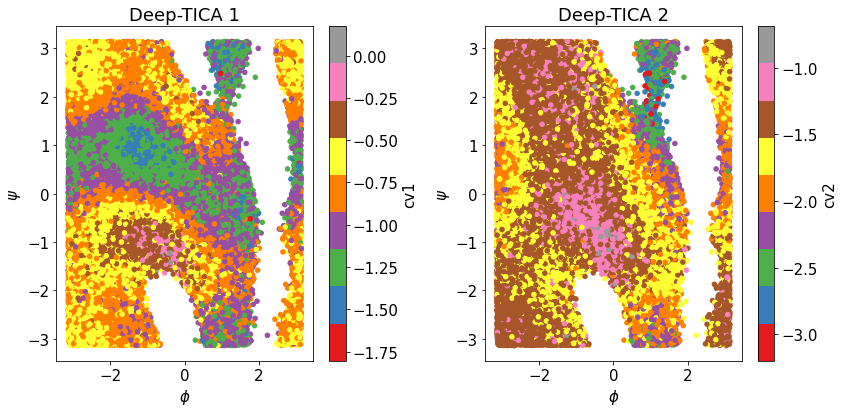

In [50]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [51]:
Boltzmann_product(model,model,X,j=0,k=1)

1.3740933830482769

# seed = 151

## DeepTICA Analysis and Export

In [52]:
torch.manual_seed(151)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -0.327      -0.307      0.293  0.034  
1000  -0.335      -0.315      0.295  0.040  
1500  -0.344      -0.320      0.298  0.046  
2000  -0.377      -0.333      0.314  0.062  
INFO: Early stopping
2455  -0.407      -0.336      0.324  0.082  
timescales:  [7.9953947 3.6019726]
eigenvalues:  [0.32444215 0.08219745]
gap:  0.24224469


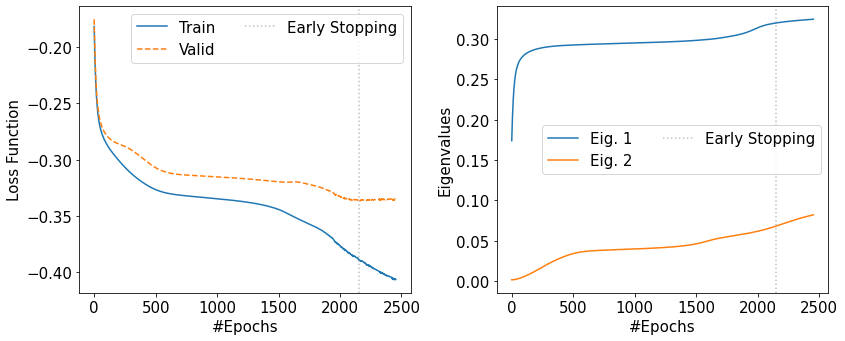

In [53]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [54]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

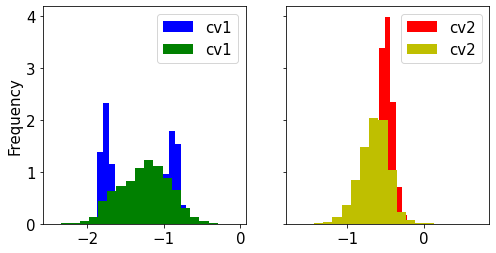

In [55]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

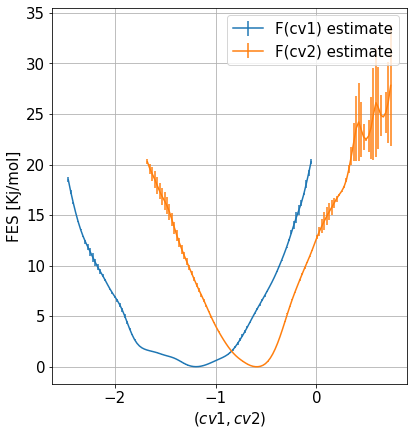

In [56]:
fes_1d(data_complete,sim_parameters)

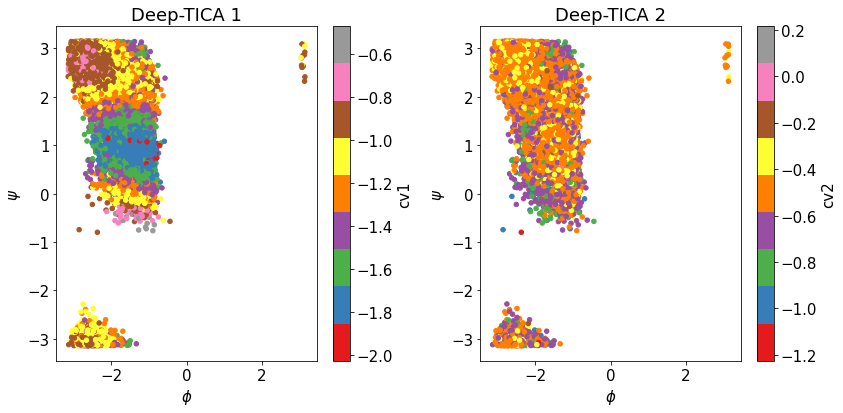

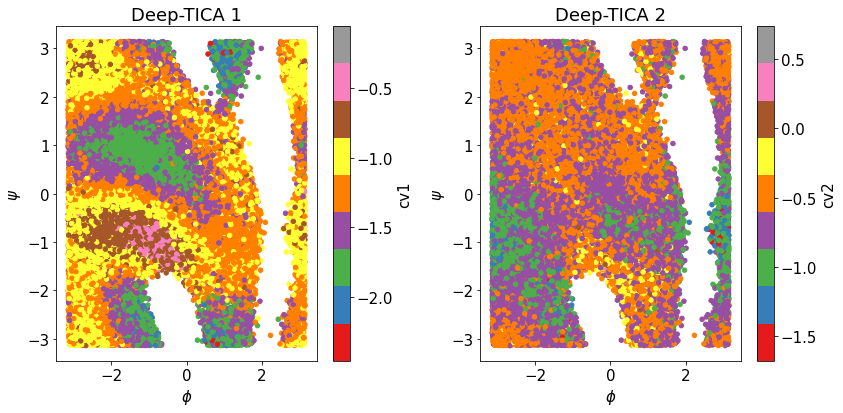

In [57]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [58]:
Boltzmann_product(model,model,X,j=0,k=1)

0.6765623082945993

# Seed = 500

## DeepTICA Analysis and Export

In [59]:
torch.manual_seed(500)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

# append model
models.append(model)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -0.320      -0.299      0.294  0.026  
1000  -0.339      -0.331      0.299  0.040  
1500  -0.372      -0.337      0.313  0.059  
INFO: Early stopping
1579  -0.379      -0.336      0.315  0.064  
timescales:  [7.784278  3.2696478]
eigenvalues:  [0.31468707 0.06376251]
gap:  0.25092456


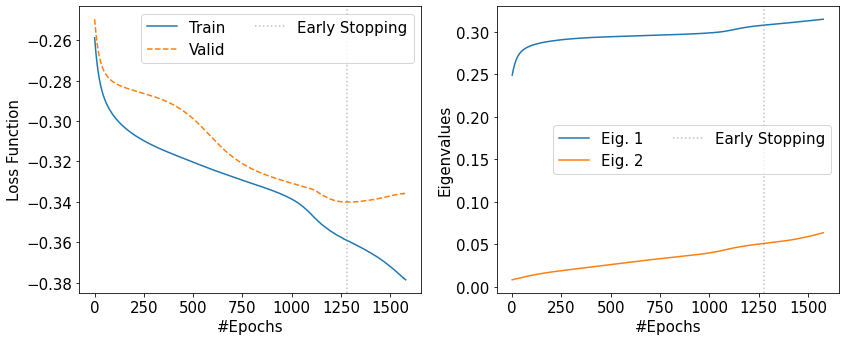

In [60]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [61]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

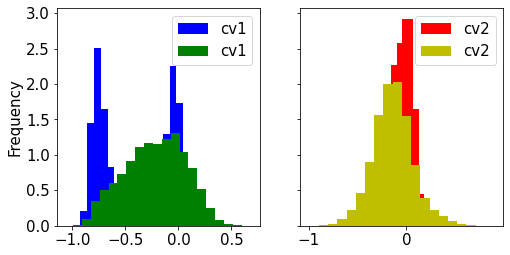

In [62]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

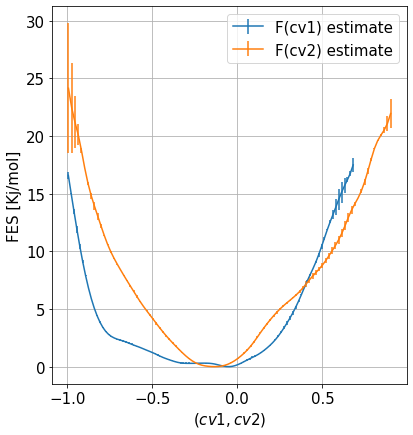

In [63]:
fes_1d(data_complete,sim_parameters)

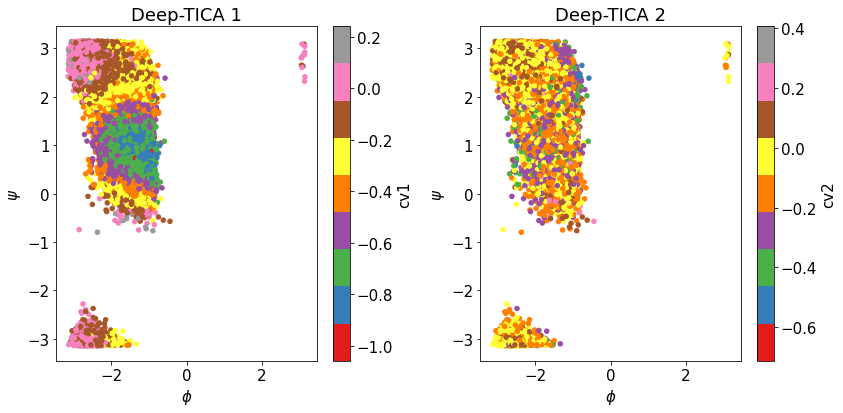

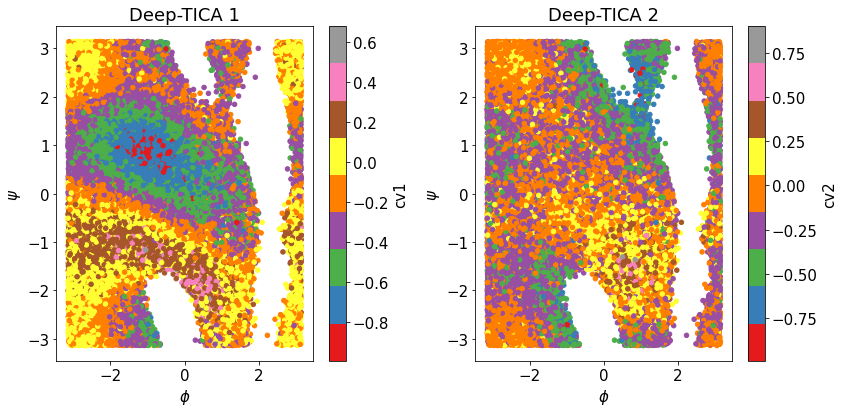

In [64]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [65]:
Boltzmann_product(model,model,X,j=0,k=1)

0.05949732949684063

# Plot all Deep-TICAs
## Deep-TICA 1

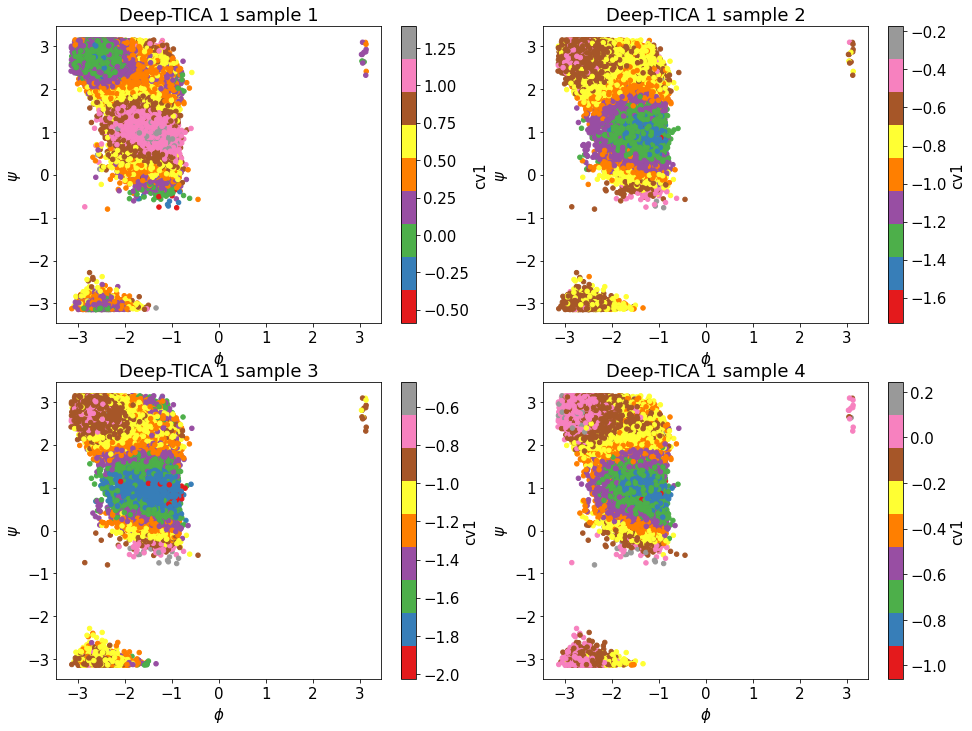

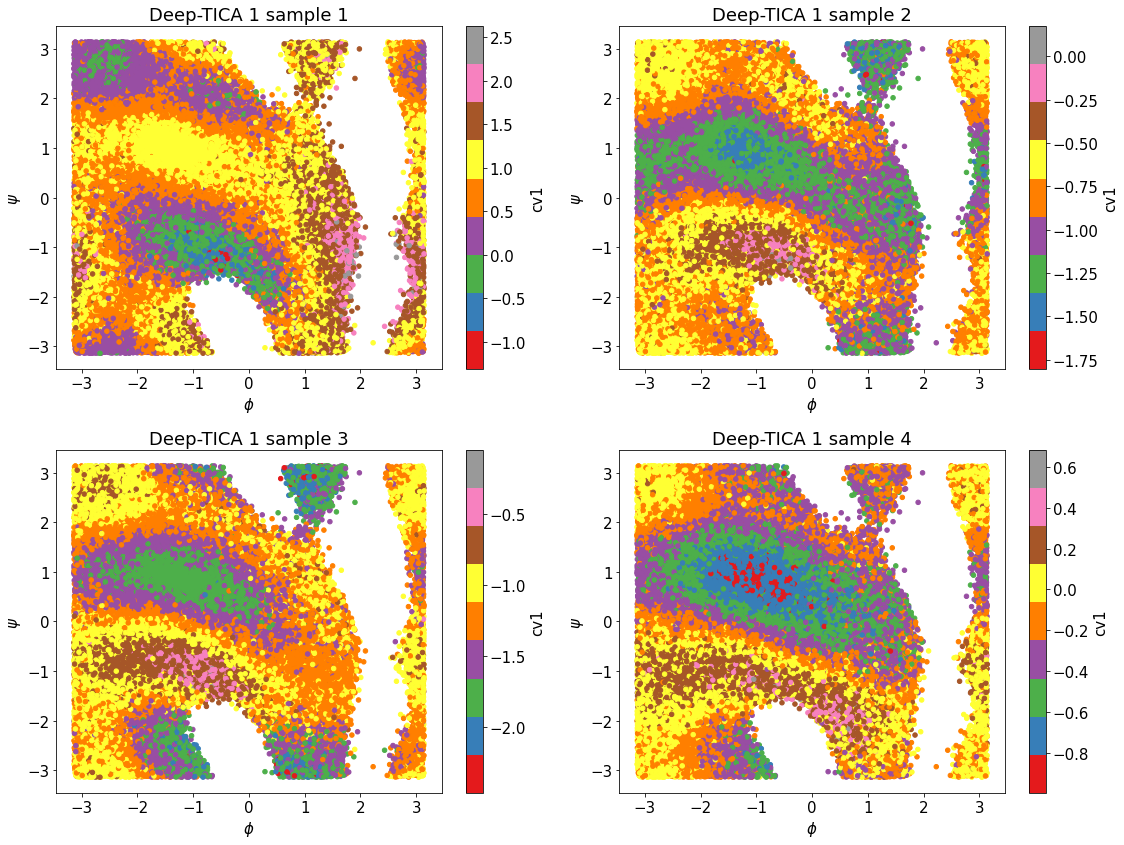

In [66]:
fig,axs1 = plt.subplots(2,2,figsize=(16,12))
fig,axs2 = plt.subplots(2,2,figsize=(16,12))

for k in range(2):
    for j in range(2):
        data["cv1"] = np.transpose(models[j+2*k](torch.Tensor(X)).detach().cpu().numpy())[0]
        data_complete["cv1"] = np.transpose(models[j+2*k](torch.Tensor(X_complete)).detach().cpu().numpy())[0]
        data.plot.scatter(y="psi",x="phi",c="cv1",cmap="Set1",ax=axs1[k][j])
        axs1[k][j].set_xlabel(r"$\phi$")
        axs1[k][j].set_ylabel(r"$\psi$")
        axs1[k][j].set_title('Deep-TICA 1 sample '+str(1+j+2*k))
        data_complete.plot.scatter(y="psi",x="phi",c="cv1",cmap="Set1",ax=axs2[k][j])
        axs2[k][j].set_xlabel(r"$\phi$")
        axs2[k][j].set_ylabel(r"$\psi$")
        axs2[k][j].set_title('Deep-TICA 1 sample '+str(1+j+2*k))

plt.tight_layout()


## Deep-TICA 2

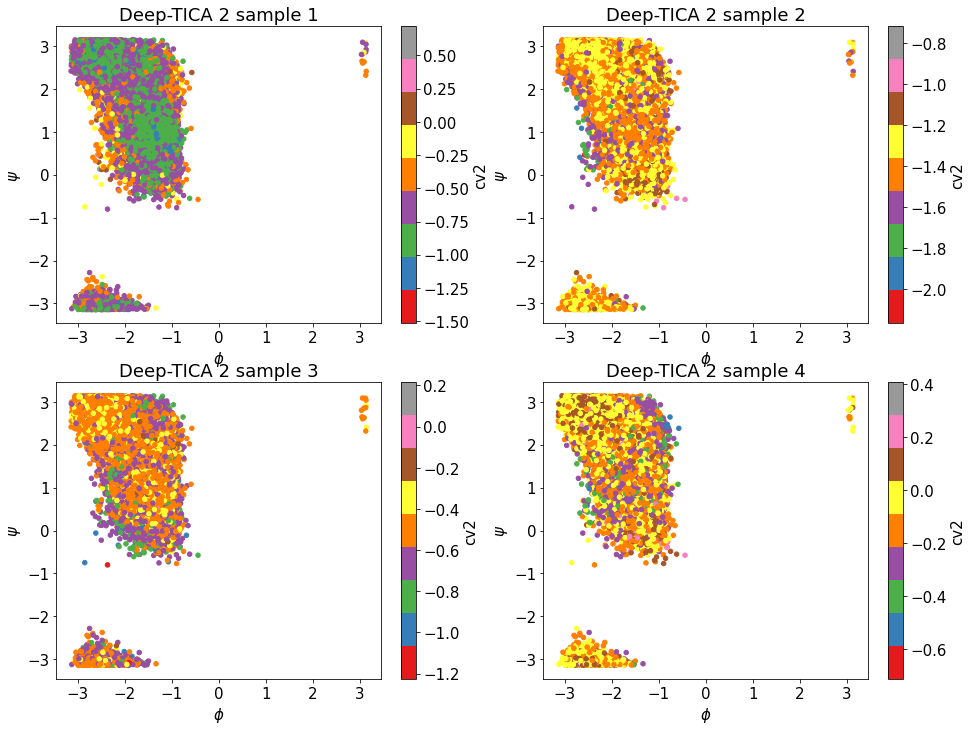

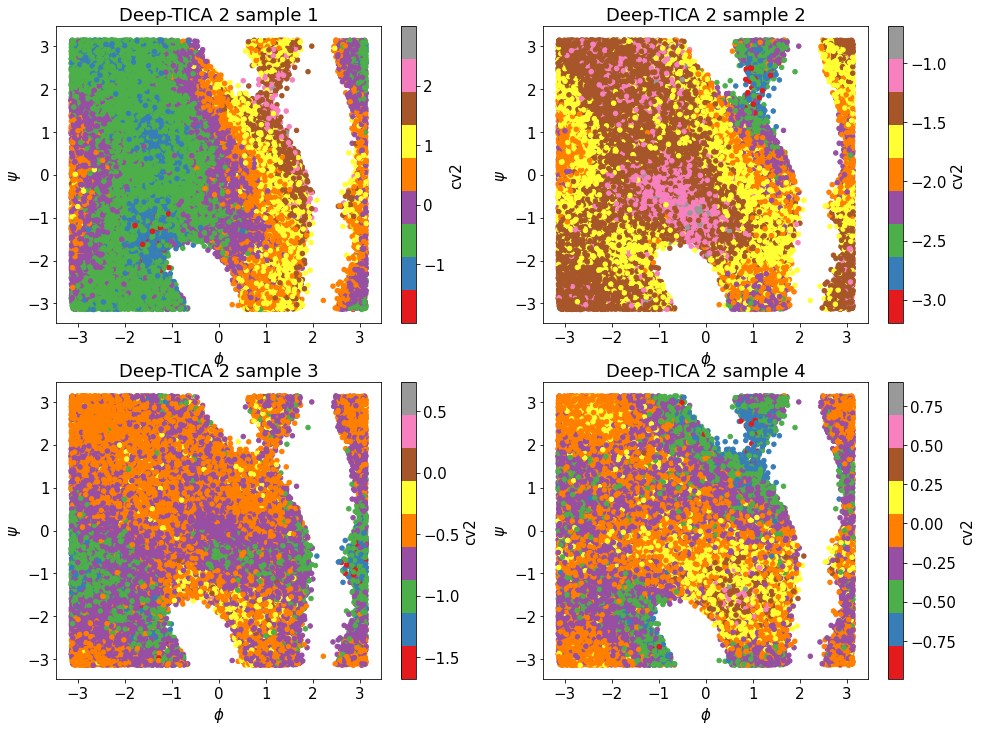

In [67]:
fig,axs1 = plt.subplots(2,2,figsize=(16,12))
fig,axs2 = plt.subplots(2,2,figsize=(16,12))

for k in range(2):
    for j in range(2):
        data["cv2"] = np.transpose(models[j+2*k](torch.Tensor(X)).detach().cpu().numpy())[1]
        data_complete["cv2"] = np.transpose(models[j+2*k](torch.Tensor(X_complete)).detach().cpu().numpy())[1]
        data.plot.scatter(y="psi",x="phi",c="cv2",cmap="Set1",ax=axs1[k][j])
        axs1[k][j].set_xlabel(r"$\phi$")
        axs1[k][j].set_ylabel(r"$\psi$")
        axs1[k][j].set_title('Deep-TICA 2 sample '+str(1+j+2*k))
        data_complete.plot.scatter(y="psi",x="phi",c="cv2",cmap="Set1",ax=axs2[k][j])
        axs2[k][j].set_xlabel(r"$\phi$")
        axs2[k][j].set_ylabel(r"$\psi$")
        axs2[k][j].set_title('Deep-TICA 2 sample '+str(1+j+2*k))

## Analysis and export model for a selected lag time  
I decide to perform the Deep-TICA Analysis for 12 different seeds

In [ ]:
'''
seeds = 4045, 151, 500, 35, 1986, 1462, 2277, 38, 1865, 4939, 3892, 3232,
print(seeds)
train_parameters["lag_time"] = 9

for seed in seeds:

    print("training with seed: ",seed)
    #fix seed (random split)
    torch.manual_seed(seed)
    model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)
    #-- export checkpoint (for loading the model back to python) and torchscript traced module --#
    save_folder = "test_different_seeds/lag"+str(train_parameters["lag_time"])+"/deeptica_seed"+str(seed)+"/"    
    try:
        os.mkdir(save_folder)
    except:
        print("already exists")
    #-- move to cpu before saving results --#
    model.to("cpu")
    model.export(save_folder)
    print("model saved")
'''